In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

In [106]:
df = pd.read_csv('data/W/gho-tobacco-control-warnings-cigarette-w8-princ-langs-a.csv')
df

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified
0,W8_princ_langs_A,Are the health warnings on cigarette packaging...,text,EMR,Eastern Mediterranean,Country,AFG,Afghanistan,Year,2022,...,NaN,NaN,NaN,NaN,NaN,No,823,NaN,EN,2023-12-13T23:00:00.000Z
1,W8_princ_langs_A,Are the health warnings on cigarette packaging...,text,AFR,Africa,Country,DZA,Algeria,Year,2022,...,NaN,NaN,NaN,NaN,NaN,No,823,Regulations are pending.,EN,2023-12-13T23:00:00.000Z
2,W8_princ_langs_A,Are the health warnings on cigarette packaging...,text,AMR,Americas,Country,BHS,Bahamas,Year,2022,...,NaN,NaN,NaN,NaN,NaN,No,823,NaN,EN,2023-12-13T23:00:00.000Z
3,W8_princ_langs_A,Are the health warnings on cigarette packaging...,text,SEAR,South-East Asia,Country,BTN,Bhutan,Year,2022,...,NaN,NaN,NaN,NaN,NaN,No,823,NaN,EN,2023-12-13T23:00:00.000Z
4,W8_princ_langs_A,Are the health warnings on cigarette packaging...,text,AFR,Africa,Country,CPV,Cabo Verde,Year,2022,...,NaN,NaN,NaN,NaN,NaN,No,823,NaN,EN,2023-12-13T23:00:00.000Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1750,W8_princ_langs_A,Are the health warnings on cigarette packaging...,text,AMR,Americas,Country,USA,United States of America,Year,2007,...,NaN,NaN,NaN,NaN,NaN,Yes,364,NaN,EN,2023-12-13T23:00:00.000Z
1751,W8_princ_langs_A,Are the health warnings on cigarette packaging...,text,AMR,Americas,Country,URY,Uruguay,Year,2007,...,NaN,NaN,NaN,NaN,NaN,Yes,364,NaN,EN,2023-12-13T23:00:00.000Z
1752,W8_princ_langs_A,Are the health warnings on cigarette packaging...,text,WPR,Western Pacific,Country,VUT,Vanuatu,Year,2007,...,NaN,NaN,NaN,NaN,NaN,Yes,364,NaN,EN,2023-12-13T23:00:00.000Z
1753,W8_princ_langs_A,Are the health warnings on cigarette packaging...,text,AMR,Americas,Country,VEN,Venezuela (Bolivarian Republic of),Year,2007,...,NaN,NaN,NaN,NaN,NaN,Yes,364,NaN,EN,2023-12-13T23:00:00.000Z


In [107]:
DATA_DIR = Path("./Data/W")  # change if your CSVs are elsewhere

files = {
    "princ_langs": DATA_DIR / "gho-tobacco-control-warnings-cigarette-w8-princ-langs-a.csv",
    "front_back": DATA_DIR / "gho-tobacco-control-warnings-cigarettes-w2-pc-front-back-a.csv",
    "font_spec": DATA_DIR / "gho-tobacco-control-warnings-cigarettes-w6-font-a.csv",
    "rotation": DATA_DIR / "gho-tobacco-control-warnings-cigarettes-w7-rotation-a.csv",
    "graphic": DATA_DIR / "gho-tobacco-control-warnings-cigarettes-w10-graphic-a.csv",
    "smokeless_law": DATA_DIR / "gho-tobacco-control-warnings-smokeless-w1-hw-law-c.csv",
}


def read_csv_any(path: Path) -> pd.DataFrame:
    for enc in ["utf-8-sig", "utf-8", "latin-1"]:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            pass
    return pd.read_csv(path, engine="python")


raw = {k: read_csv_any(p) for k, p in files.items()}

KEEP = ["ParentLocation", "Location", "Period", "Value", "ValueType", "IndicatorCode", "Indicator"]


def yesno_to_flag(s: pd.Series) -> pd.Series:
    x = s.fillna("").str.strip().str.lower()
    out = pd.Series(np.nan, index=s.index, dtype="float")
    out[x.isin(["yes", "y"])] = 1.0
    out[x.isin(["no", "n"])] = 0.0
    return out


def smokeless_law_flag(s: pd.Series) -> pd.Series:
    x = s.fillna("").str.strip().str.lower()
    out = pd.Series(np.nan, index=s.index, dtype="float")
    out[x.eq("yes")] = 1.0
    out[x.eq("no")] = 0.0
    # treat “Sale is banned” as protective
    out[x.eq("sale is banned")] = 1.0
    return out


def base_df(raw_key, rename_to, mapper=None, numeric=False):
    df = raw[raw_key][KEEP].rename(columns={"ParentLocation": "Region"}).copy()
    df["feature"] = rename_to
    if numeric:
        df["flag"] = pd.to_numeric(df["Value"], errors="coerce")
    else:
        df["flag"] = (mapper(df["Value"]) if mapper else yesno_to_flag(df["Value"]))
    return df


# Build long panel
df_princ = base_df("princ_langs", "principal_languages")
df_font = base_df("font_spec", "font_spec")
df_rot = base_df("rotation", "rotation")
df_graph = base_df("graphic", "graphic")
df_fb = base_df("front_back", "front_back_pct", numeric=True)
df_smokeless = base_df("smokeless_law", "smokeless_law", mapper=smokeless_law_flag)

features = pd.concat([df_princ, df_font, df_rot, df_graph, df_fb, df_smokeless], ignore_index=True)

# Pass/fail rule (≥50% for front+back)
features["pass"] = features["flag"]
is_fb = features["feature"].eq("front_back_pct")
features.loc[is_fb, "pass"] = (features.loc[is_fb, "flag"] >= 50).astype(float)
features.loc[~is_fb, "pass"] = features.loc[~is_fb, "flag"]

features.to_csv("w_features_clean.csv", index=False)

# Wide per country-year + best-practice composite
feat_list = ["graphic", "rotation", "principal_languages", "font_spec", "front_back_pct"]
wide = (features[features["feature"].isin(feat_list + ["smokeless_law"])]
        .pivot_table(index=["Region", "Location", "Period"], columns="feature", values="pass", aggfunc="max")
        .reset_index())

wide["best_practice_cig"] = (
        wide[["graphic", "rotation", "principal_languages", "font_spec", "front_back_pct"]].fillna(0).sum(axis=1) == 5
).astype(int)

# Latest year slices
latest_year = wide.groupby(["Region", "Location"])["Period"].transform("max")
latest = wide[wide["Period"].eq(latest_year)].copy()
latest.to_csv("w_country_summary_latest.csv", index=False)

region_summary = (latest.groupby("Region")[["graphic", "rotation", "principal_languages",
                                            "font_spec", "front_back_pct", "best_practice_cig", "smokeless_law"]]
                  .mean(numeric_only=True).reset_index())
region_summary.to_csv("w_region_summary_latest.csv", index=False)

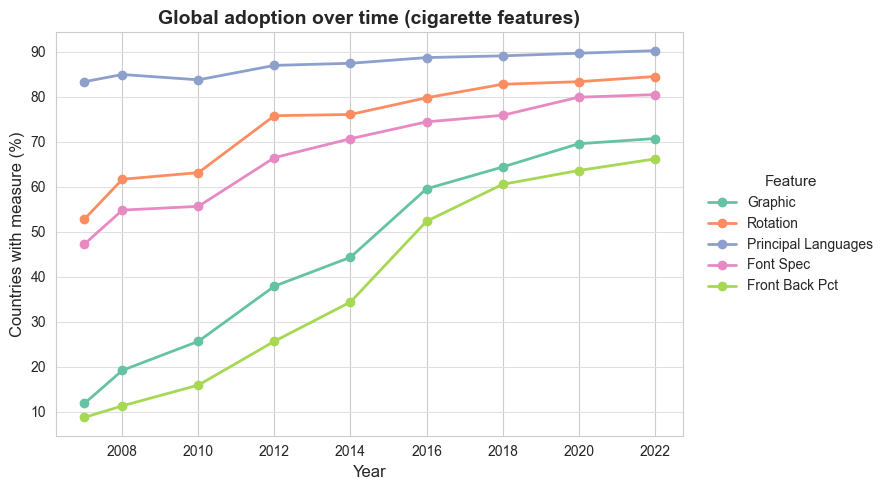

In [108]:
plt.figure(figsize=(9, 5))
palette = sns.color_palette("Set2", n_colors=len(feat_list))

global_time = (
    features[features["feature"].isin(feat_list)]
    .groupby(["Period", "feature"])
    .agg(pass_rate=("pass", lambda s: np.nanmean(s) * 100))
    .reset_index()
)

for i, feat in enumerate(feat_list):
    g = global_time[global_time["feature"] == feat]
    plt.plot(
        g["Period"], g["pass_rate"],
        marker="o", linewidth=2, label=feat.replace("_", " ").title(),
        color=palette[i]
    )

plt.title("Global adoption over time (cigarette features)", fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Countries with measure (%)", fontsize=12)
plt.legend(title="Feature", frameon=False, fontsize=10, title_fontsize=11, loc="center left",
           bbox_to_anchor=(1.02, 0.5))
plt.grid(axis="y", color="#e0e0e0", linewidth=0.8)
plt.tight_layout()
plt.show()

> **Titolo**: Adozione globale nel tempo (2006–2022)
>
> **Cosa mostra**: % di Paesi che adottano ciascuna delle 5 feature nei vari anni.
>
> Messaggi chiave
> - Crescita netta su tutte le feature.
> - Le salite più marcate riguardano pittoriche e ≥50% fronte+retro.
> - Lingue principali è alta da anni (quasi universale).
> - Rotazione e specifiche tipografiche migliorano con continuità.
>
> Perché importa
> - Mostra la diffusione globale delle componenti della best-practice W.

>**Title**: Global adoption over time (2006–2022)
>
> **What it shows**: % of countries adopting each of the 5 cigarette features by year.
>
> Key messages
> - Significant growth across all features.
> - Biggest gains in pictorial warnings and ≥50% front&back.
> - Principal language(s) has been high for years.
> - Rotation and typography climb consistently.
>
> Why it matters
> - Shows the global diffusion of the W best-practice components.


In [109]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = Path("./data/W/clusterA")  # cambia se i CSV non sono nella stessa cartella

files = {
    # Law mandates
    "law_cig": DATA_DIR / "Tobacco health warnings appear on cigarette packages, law mandates.csv",
    "law_osm": DATA_DIR / "Tobacco health warnings appear on other smoked tobacco packages, law mandates.csv",
    "law_sml": DATA_DIR / "Tobacco health warnings appear on smokeless tobacco packages, law mandates.csv",
    # Each package & outside packaging
    "each_cig": DATA_DIR / "Tobacco health warnings appear on each cigarette package and any outside packaging and labelling used in the retail sale.csv",
    "each_osm": DATA_DIR / "Tobacco health warnings appear on each other smoked tobacco package and any outside packaging and labelling used in the retail sale.csv",
    "each_sml": DATA_DIR / "Tobacco health warnings appear on each smokeless tobacco package and any outside packaging and labelling used in the retail sale.csv",
    # Front & back %
    "fb_cig": DATA_DIR / "Tobacco warning front and back of cigarette packaging, % of principal display area mandated.csv",
    "fb_osm": DATA_DIR / "Tobacco warning  front and back of other smoked tobacco packaging, % of principal display area mandated to be covered by health warnings.csv",
    "fb_sml": DATA_DIR / "Tobacco warning front and back of smokeless tobacco packaging, % of principal display area mandated to be covered by health warnings.csv",
}


def read_csv_any(p: Path) -> pd.DataFrame:
    for enc in ["utf-8-sig", "utf-8", "latin-1"]:
        try:
            return pd.read_csv(p, encoding=enc)
        except Exception:
            pass
    return pd.read_csv(p, engine="python")


raw = {k: read_csv_any(p) for k, p in files.items()}

KEEP = ["ParentLocation", "Location", "Period", "Value", "ValueType", "IndicatorCode", "Indicator"]
REN_REGION = {"ParentLocation": "Region"}


def yesno_flag(s: pd.Series) -> pd.Series:
    x = s.fillna("").str.strip().str.lower()
    out = pd.Series(np.nan, index=s.index, dtype="float")
    out[x.isin(["yes", "y"])] = 1.0
    out[x.isin(["no", "n"])] = 0.0
    return out


def pct_from_value(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")


def build_table(df: pd.DataFrame, feature_name: str, mapper) -> pd.DataFrame:
    t = df[KEEP].rename(columns=REN_REGION).copy()
    t["feature"] = feature_name
    t["val"] = mapper(t["Value"])
    return t


tables = []
# Law mandate flags
tables += [build_table(raw["law_cig"], "law_cig", yesno_flag)]
tables += [build_table(raw["law_osm"], "law_osm", yesno_flag)]
tables += [build_table(raw["law_sml"], "law_sml", yesno_flag)]
# Each package flags
tables += [build_table(raw["each_cig"], "eachpkg_cig", yesno_flag)]
tables += [build_table(raw["each_osm"], "eachpkg_osm", yesno_flag)]
tables += [build_table(raw["each_sml"], "eachpkg_sml", yesno_flag)]
# Front & back % (numeric)
tables += [build_table(raw["fb_cig"], "fbpct_cig", pct_from_value)]
tables += [build_table(raw["fb_osm"], "fbpct_osm", pct_from_value)]
tables += [build_table(raw["fb_sml"], "fbpct_sml", pct_from_value)]

long = pd.concat(tables, ignore_index=True)

# Create pass flags
long["pass"] = np.nan
for k in ["law_cig", "law_osm", "law_sml", "eachpkg_cig", "eachpkg_osm", "eachpkg_sml"]:
    m = long["feature"].eq(k)
    long.loc[m, "pass"] = long.loc[m, "val"]

for k in ["fbpct_cig", "fbpct_osm", "fbpct_sml"]:
    m = long["feature"].eq(k)
    long.loc[m, "pass"] = (long.loc[m, "val"] >= 50).astype(float)

# Wide per country-year
wide = (long.pivot_table(index=["Region", "Location", "Period"], columns="feature",
                         values="pass", aggfunc="max")
        .reset_index())

# Strict compliance per product: law==1 & eachpkg==1 & fb>=50
for prd in ["cig", "osm", "sml"]:
    cols = [f"law_{prd}", f"eachpkg_{prd}", f"fbpct_{prd}"]
    wide[f"A_strict_{prd}"] = (wide[cols].fillna(0).sum(axis=1) == 3).astype(int)

# Latest year slice per country
wide["latest_year"] = wide.groupby(["Region", "Location"])["Period"].transform("max")
latest = wide[wide["Period"].eq(wide["latest_year"])].copy()

# Save summaries
wide.to_csv("clusterA_panel.csv", index=False)
latest.to_csv("clusterA_latest.csv", index=False)

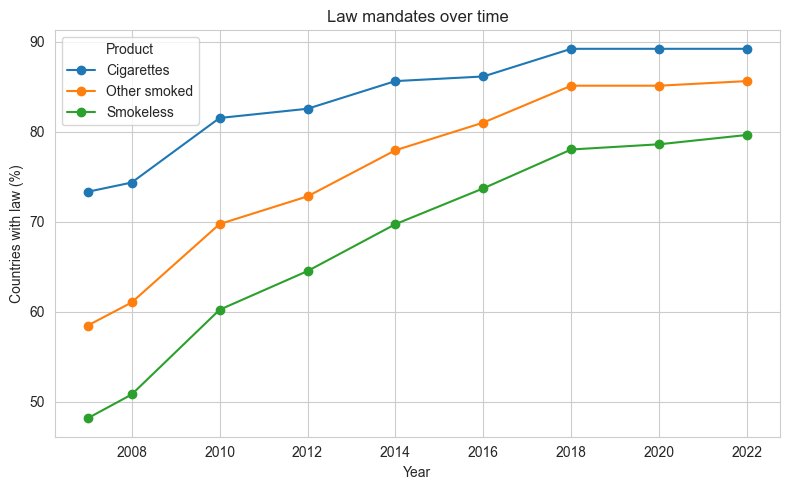

In [110]:
# ---------- Plot 1: Law mandates over time ----------
global_law = (long[long["feature"].isin(["law_cig", "law_osm", "law_sml"])]
              .groupby(["feature", "Period"])
              .agg(share=("pass", lambda s: np.nanmean(s) * 100)).reset_index())

plt.figure(figsize=(8, 5))
for feat, label in [("law_cig", "Cigarettes"), ("law_osm", "Other smoked"), ("law_sml", "Smokeless")]:
    sub = global_law[global_law["feature"].eq(feat)]
    plt.plot(sub["Period"], sub["share"], marker="o", label=label)
plt.title("Law mandates over time")
plt.xlabel("Year")
plt.ylabel("Countries with law (%)")
plt.legend(title="Product")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

- Mostra la quota di Paesi che prevedono per legge le avvertenze su pacchetto per sigarette (CIG), altri prodotti da fumo (OSM) e senza fumo (SML).
- Trend in crescita per tutte le categorie; CIG parte più in alto e resta davanti, OSM converge, SML è più indietro ma migliora con costanza.

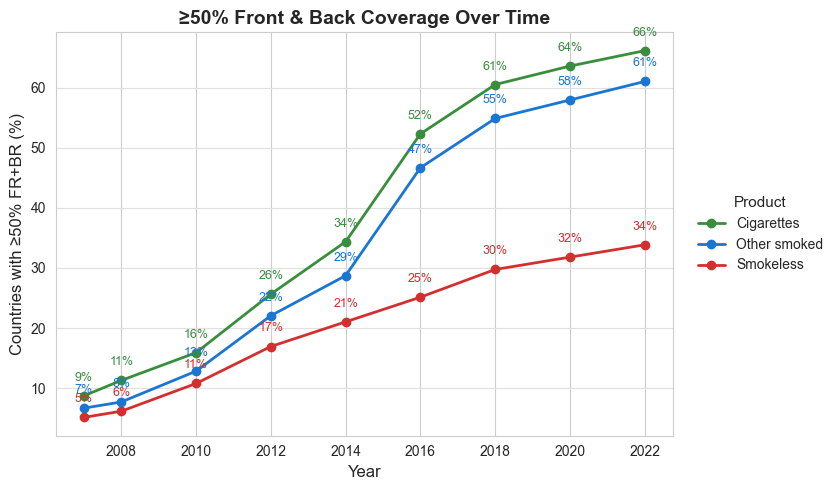

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

# Custom color palette for tobacco control/health themes
fb_palette = ["#388e3c", "#1976d2", "#d32f2f"]  # green, blue, red

plt.figure(figsize=(8.5, 5))
for i, lab in enumerate(["Cigarettes", "Other smoked", "Smokeless"]):
    sub = trend_fb[trend_fb["label"] == lab]
    plt.plot(
        sub["Period"], sub["share"],
        marker="o", linewidth=2, label=lab,
        color=fb_palette[i]
    )
    # Add value labels
    for x, y in zip(sub["Period"], sub["share"]):
        plt.text(x, y + 2, f"{y:.0f}%", ha="center", va="bottom", fontsize=9, color=fb_palette[i])

plt.title("≥50% Front & Back Coverage Over Time", fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Countries with ≥50% FR+BR (%)", fontsize=12)
plt.legend(title="Product", frameon=False, fontsize=10, title_fontsize=11, loc="center left",
           bbox_to_anchor=(1.02, 0.5))
plt.grid(axis="y", color="#e0e0e0", linewidth=0.8)
plt.tight_layout()
plt.show()

- Percentuale di Paesi che raggiunge almeno il 50% di copertura fronte+retro del pacchetto (soglia di “**buona pratica**”).
- Grande accelerazione dopo il 2014 per CIG e OSM; SML aumenta più lentamente → probabile gap normativo sui prodotti senza fumo.

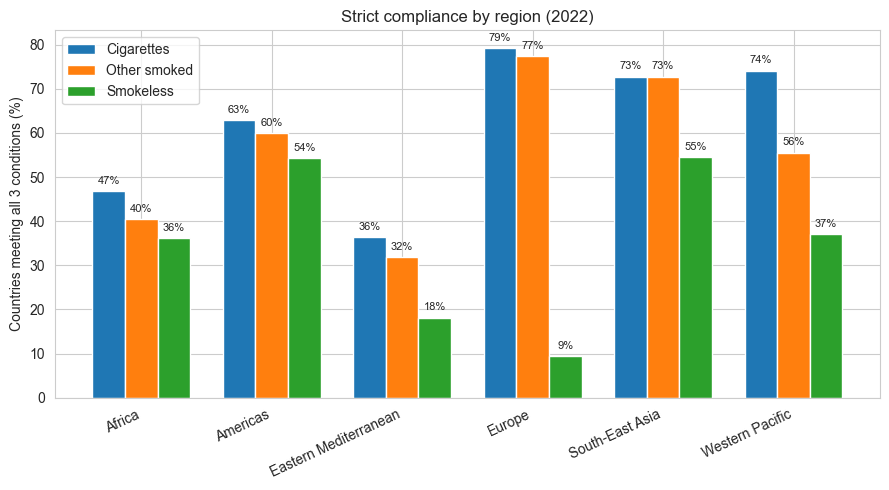

In [112]:
# ---------- Plot 3: 2022 by-region — Strict Cluster-A compliance ----------
yr_latest = int(long["Period"].max())
byreg = (latest.groupby("Region")[["A_strict_cig", "A_strict_osm", "A_strict_sml"]]
         .mean(numeric_only=True).mul(100).reset_index())

x = np.arange(len(byreg["Region"]))
w = 0.25
plt.figure(figsize=(9, 5))
plt.bar(x - w, byreg["A_strict_cig"], width=w, label="Cigarettes")
plt.bar(x, byreg["A_strict_osm"], width=w, label="Other smoked")
plt.bar(x + w, byreg["A_strict_sml"], width=w, label="Smokeless")
plt.title(f"Strict compliance by region ({yr_latest})")
plt.ylabel("Countries meeting all 3 conditions (%)")
plt.xticks(x, byreg["Region"], rotation=25, ha="right")
for i, v in enumerate(byreg["A_strict_cig"]): plt.text(x[i] - w, v + 1.2, f"{v:.0f}%", ha="center", va="bottom",
                                                       fontsize=8)
for i, v in enumerate(byreg["A_strict_osm"]): plt.text(x[i], v + 1.2, f"{v:.0f}%", ha="center", va="bottom", fontsize=8)
for i, v in enumerate(byreg["A_strict_sml"]): plt.text(x[i] + w, v + 1.2, f"{v:.0f}%", ha="center", va="bottom",
                                                       fontsize=8)
plt.legend()
plt.tight_layout()
plt.show()

- Conformità “strict” per prodotto = (Legge) ∧ (Copertura ≥50% FR+BR) ∧ (“su ogni pacchetto & packaging esterno”).
- Europa e Sud-Est Asiatico guidano; Africa ed Est Mediterraneo sotto media, soprattutto su SML.
- Uso ideale in slide per evidenziare priorità regionali.

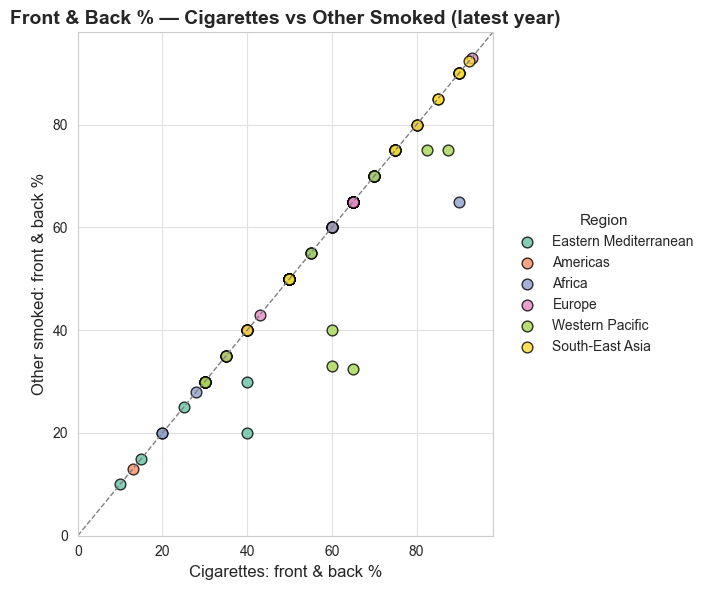

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assign a color to each region
regions = scatter_df["Region"].unique()
palette = dict(zip(regions, sns.color_palette("Set2", n_colors=len(regions))))

plt.figure(figsize=(7, 6))
for region in regions:
    sub = scatter_df[scatter_df["Region"] == region]
    plt.scatter(sub["fbpct_cig"], sub["fbpct_osm"], label=region, color=palette[region], alpha=0.8, edgecolor="k", s=60)

mx = max(scatter_df[["fbpct_cig", "fbpct_osm"]].max()) + 5
plt.plot([0, mx], [0, mx], linestyle="--", color="gray", linewidth=1)
plt.title("Front & Back % — Cigarettes vs Other Smoked (latest year)", fontsize=14, fontweight="bold")
plt.xlabel("Cigarettes: front & back %", fontsize=12)
plt.ylabel("Other smoked: front & back %", fontsize=12)
plt.xlim(0, mx)
plt.ylim(0, mx)
plt.grid(True, axis="both", color="#e0e0e0", linewidth=0.8)
plt.legend(title="Region", frameon=False, fontsize=10, title_fontsize=11, bbox_to_anchor=(1.02, 0.5), loc="center left")
plt.tight_layout()
plt.show()

- Ogni punto è un Paese (ultimo anno disponibile). La linea tratteggiata è l’uguaglianza y=x.
- Molti Paesi stanno sotto la diagonale → OSM spesso ha coperture inferiori rispetto alle CIG.

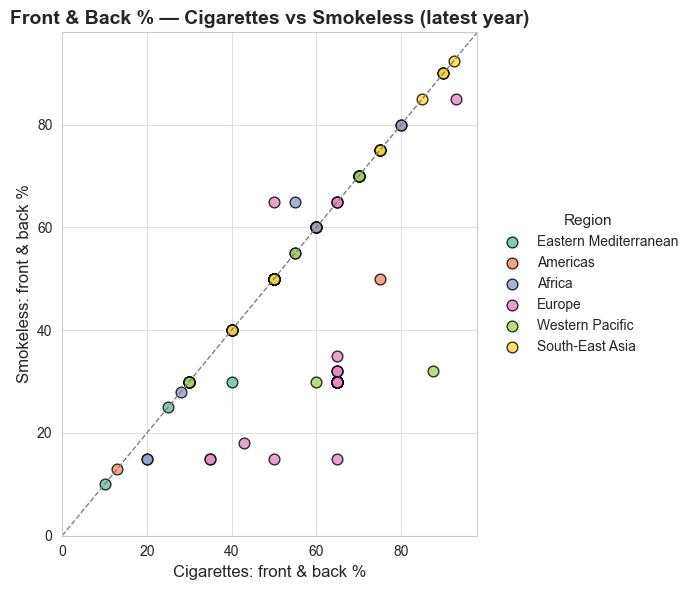

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assign a color to each region
regions = scatter_df["Region"].unique()
palette = dict(zip(regions, sns.color_palette("Set2", n_colors=len(regions))))

plt.figure(figsize=(7, 6))
for region in regions:
    sub = scatter_df[scatter_df["Region"] == region]
    plt.scatter(
        sub["fbpct_cig"], sub["fbpct_sml"],
        label=region, color=palette[region], alpha=0.8, edgecolor="k", s=60
    )

mx = max(scatter_df[["fbpct_cig", "fbpct_sml"]].max()) + 5
plt.plot([0, mx], [0, mx], linestyle="--", color="gray", linewidth=1)
plt.title("Front & Back % — Cigarettes vs Smokeless (latest year)", fontsize=14, fontweight="bold")
plt.xlabel("Cigarettes: front & back %", fontsize=12)
plt.ylabel("Smokeless: front & back %", fontsize=12)
plt.xlim(0, mx)
plt.ylim(0, mx)
plt.grid(True, axis="both", color="#e0e0e0", linewidth=0.8)
plt.legend(title="Region", frameon=False, fontsize=10, title_fontsize=11, bbox_to_anchor=(1.02, 0.5), loc="center left")
plt.tight_layout()
plt.show()

- Gap ancora più evidente: parecchi Paesi con buone coperture per CIG restano indietro su SML.
- Da usare per sostenere l’argomento “allineare le categorie di prodotto”.

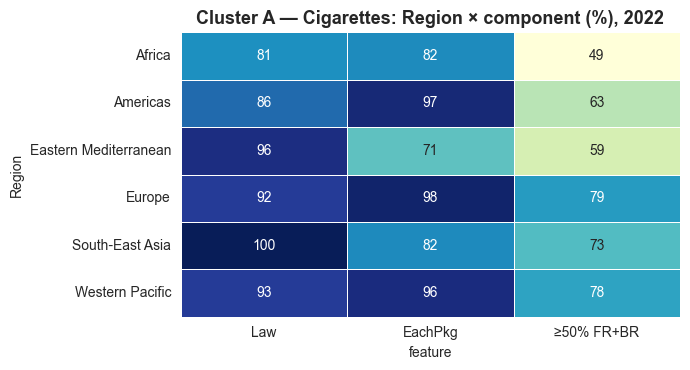

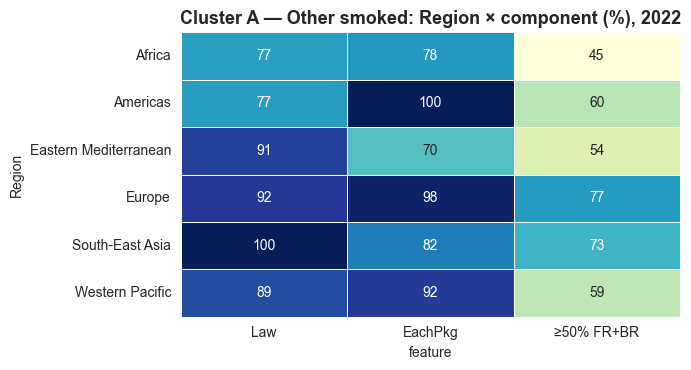

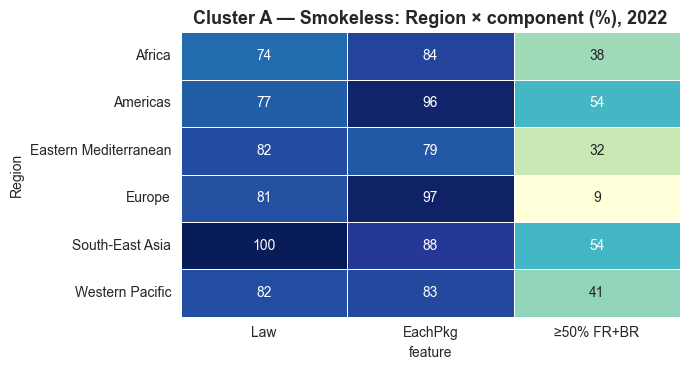

/var/folders/15/vxn06zbn0k7_72phb5gfqngh0000gn/T/ipykernel_29697/2002953353.py:25: UserWarning: Glyph 8743 (\N{LOGICAL AND}) missing from font(s) Arial.
  plt.tight_layout()
/opt/homebrew/anaconda3/envs/VisualizzazioneScientifica/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8743 (\N{LOGICAL AND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


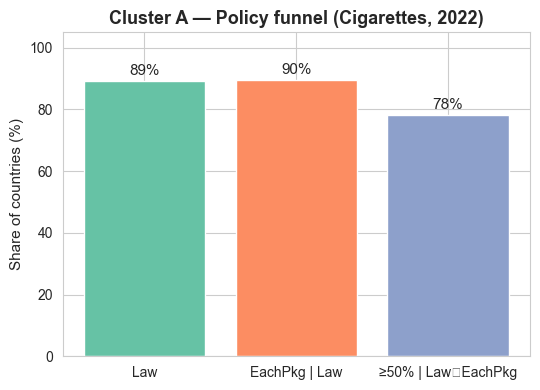

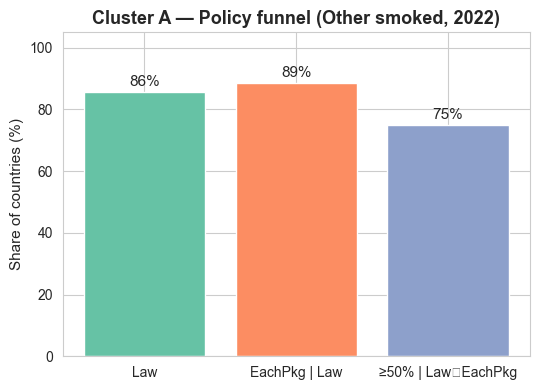

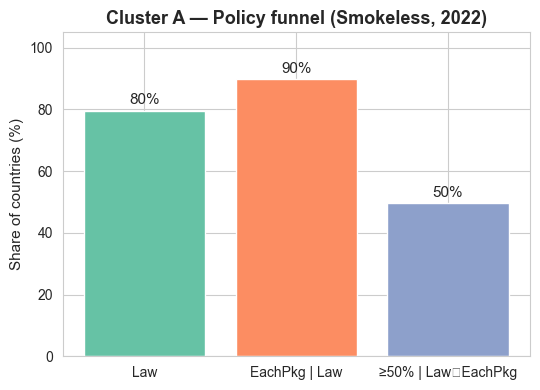

/var/folders/15/vxn06zbn0k7_72phb5gfqngh0000gn/T/ipykernel_29697/2002953353.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x="Region", y="gap_years", data=g, order=order, palette="Set2", showfliers=False)


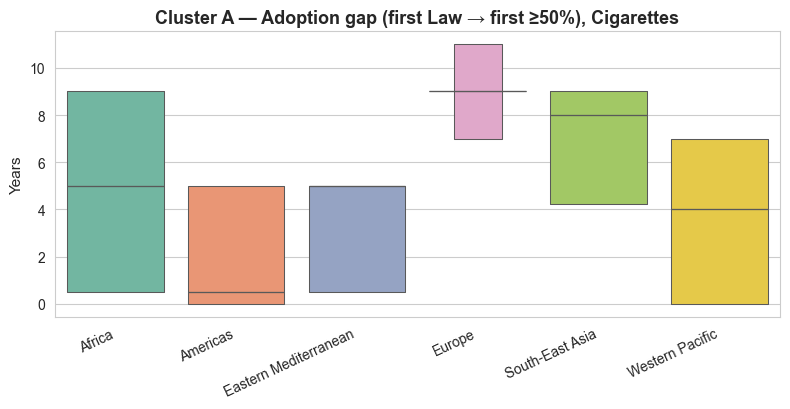

/var/folders/15/vxn06zbn0k7_72phb5gfqngh0000gn/T/ipykernel_29697/2002953353.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x="Region", y="gap_years", data=g, order=order, palette="Set2", showfliers=False)


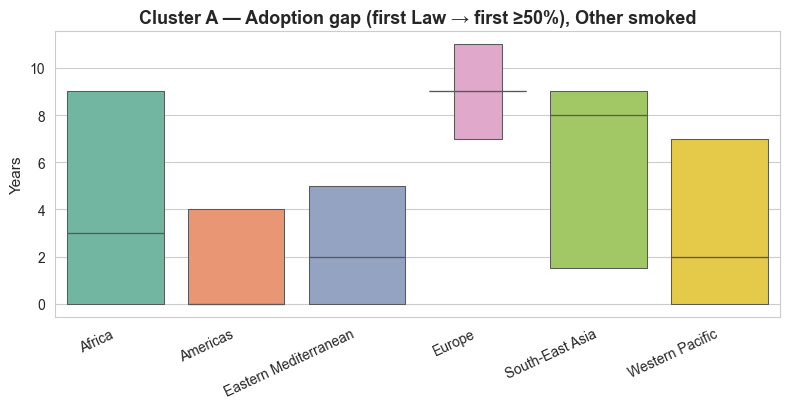

/var/folders/15/vxn06zbn0k7_72phb5gfqngh0000gn/T/ipykernel_29697/2002953353.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x="Region", y="gap_years", data=g, order=order, palette="Set2", showfliers=False)


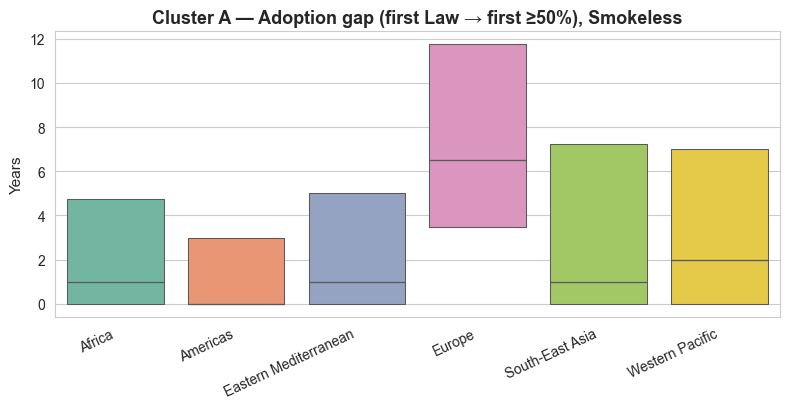

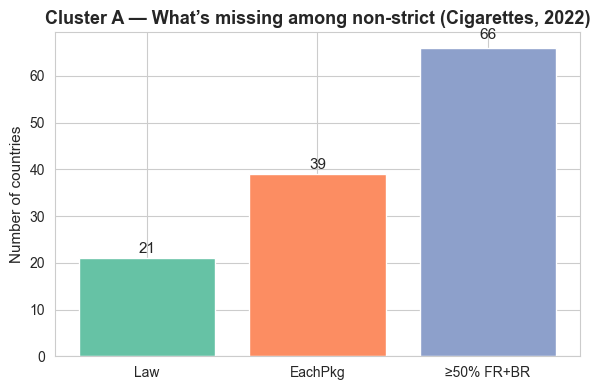

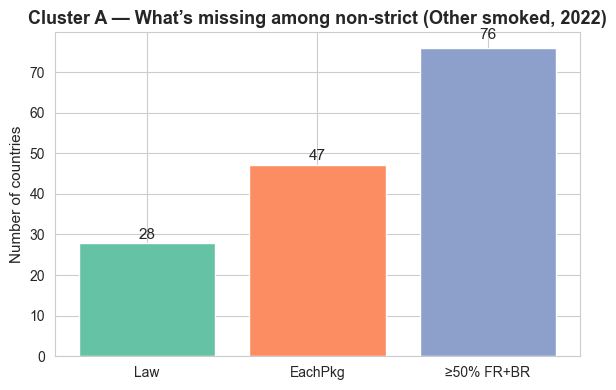

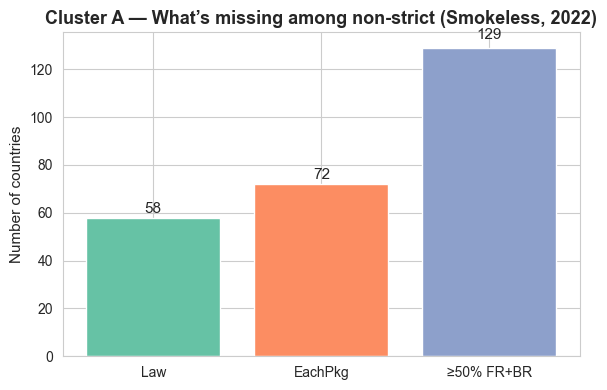

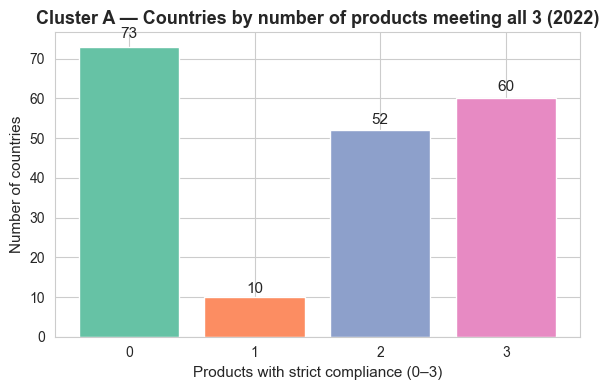

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# 6) Heatmaps per prodotto (improved)
for key, title in [("cig", "Cigarettes"), ("osm", "Other smoked"), ("sml", "Smokeless")]:
    tbl = region_component_table_latest(latest, key)
    plt.figure(figsize=(7, 3.8))
    sns.heatmap(tbl, annot=True, fmt=".0f", cmap="YlGnBu", cbar=False, linewidths=0.5, annot_kws={"fontsize": 10})
    plt.title(f"Cluster A — {title}: Region × component (%), {yr_latest}", fontsize=13, fontweight="bold")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# 7) Policy funnel (improved)
for key, title in [("cig", "Cigarettes"), ("osm", "Other smoked"), ("sml", "Smokeless")]:
    s1, s2, s3 = funnel_shares(latest, key)
    xs, ys = ["Law", "EachPkg | Law", "≥50% | Law∧EachPkg"], [s1, s2, s3]
    plt.figure(figsize=(5.5, 4))
    bars = plt.bar(xs, ys, color=sns.color_palette("Set2", 3))
    for bar, v in zip(bars, ys):
        if pd.notna(v): plt.text(bar.get_x() + bar.get_width() / 2, v + 2, f"{v:.0f}%", ha="center", fontsize=11)
    plt.ylim(0, 105)
    plt.title(f"Cluster A — Policy funnel ({title}, {yr_latest})", fontsize=13, fontweight="bold")
    plt.ylabel("Share of countries (%)", fontsize=11)
    plt.tight_layout()
    plt.show()

# 8) Adoption gap (anni) (improved)
for key, title in [("cig", "Cigarettes"), ("osm", "Other smoked"), ("sml", "Smokeless")]:
    g = adoption_gap_per_country(long, key)
    order = sorted(g["Region"].unique())
    plt.figure(figsize=(8, 4.2))
    sns.boxenplot(x="Region", y="gap_years", data=g, order=order, palette="Set2", showfliers=False)
    plt.title(f"Cluster A — Adoption gap (first Law → first ≥50%), {title}", fontsize=13, fontweight="bold")
    plt.ylabel("Years", fontsize=11)
    plt.xlabel("")
    plt.xticks(rotation=25, ha="right")
    plt.tight_layout()
    plt.show()

# 9) Pareto dei mancanti (improved)
for key, title in [("cig", "Cigarettes"), ("osm", "Other smoked"), ("sml", "Smokeless")]:
    m = missing_component_counts(latest, key)
    plt.figure(figsize=(6, 4))
    bars = plt.bar(m.index, m.values, color=sns.color_palette("Set2", 3))
    for bar, v in zip(bars, m.values):
        plt.text(bar.get_x() + bar.get_width() / 2, v + max(1, v * 0.03), f"{int(v)}", ha="center", fontsize=11)
    plt.title(f"Cluster A — What’s missing among non-strict ({title}, {yr_latest})", fontsize=13, fontweight="bold")
    plt.ylabel("Number of countries", fontsize=11)
    plt.tight_layout()
    plt.show()

# 10) Quanti prodotti “strict” per Paese (improved)
strict_counts = (latest[["A_strict_cig", "A_strict_osm", "A_strict_sml"]]
                 .fillna(0).astype(int).sum(axis=1).value_counts().sort_index())
plt.figure(figsize=(6, 4))
bars = plt.bar([str(i) for i in strict_counts.index], strict_counts.values, color=sns.color_palette("Set2", 4))
for bar, v in zip(bars, strict_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, v + max(1, v * 0.03), f"{int(v)}", ha="center", fontsize=11)
plt.title(f"Cluster A — Countries by number of products meeting all 3 ({yr_latest})", fontsize=13, fontweight="bold")
plt.xlabel("Products with strict compliance (0–3)", fontsize=11)
plt.ylabel("Number of countries", fontsize=11)
plt.tight_layout()
plt.show()